In [1]:
from pyiron import Project

In [2]:
pr = Project("demo")

In [3]:
pr.path

'/home/jovyan/demo/'

# structures 

In [4]:
structure = pr.create_ase_bulk("Al", cubic=True)

In [5]:
structure

Al: [0. 0. 0.]
Al: [0.    2.025 2.025]
Al: [2.025 0.    2.025]
Al: [2.025 2.025 0.   ]
pbc: [ True  True  True]
cell: 
[[4.05 0.   0.  ]
 [0.   4.05 0.  ]
 [0.   0.   4.05]]

In [6]:
structure.plot3d()

NGLWidget()

In [7]:
del structure[-1]

In [8]:
structure

Al: [0. 0. 0.]
Al: [0.    2.025 2.025]
Al: [2.025 0.    2.025]
pbc: [ True  True  True]
cell: 
[[4.05 0.   0.  ]
 [0.   4.05 0.  ]
 [0.   0.   4.05]]

In [9]:
neigh = structure.get_neighbors(cutoff=3.0)

In [10]:
neigh.indices

array([[1, 2, 1, 2, 2, 1, 2, 1],
       [0, 0, 2, 2, 2, 0, 0, 2],
       [0, 1, 1, 0, 0, 1, 0, 1]])

# Lammps calculation 

In [11]:
job = pr.create_job(
    job_type=pr.job_type.Lammps,
    job_name="lmp_large"
)

In [12]:
job.structure = structure.repeat([4,4,4])

In [13]:
job.potential = job.list_potentials()[0]

In [14]:
job.calc_md(temperature=800, n_ionic_steps=10000)

In [15]:
job.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all nvt temp 800.0 800.0 0.1,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


In [16]:
job.input.control["run"] = 10010

In [17]:
job.server.run_mode.non_modal = True 

In [18]:
job.run()

The job lmp_large was saved and received the ID: 1


2020-08-07 16:10:11,887 - pyiron_log - INFO - job: lmp_large id: 1, status: submitted, run job (modal)
2020-08-07 16:10:22,078 - pyiron_log - INFO - job: lmp_large id: 1, status: collect, output: LAMMPS (3 Mar 2020)
Reading data file ...
  orthogonal box = (0 0 0) to (16.2 16.2 16.2)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  192 atoms
  read_data CPU = 0.00149894 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 9.5
  ghost atom cutoff = 9.5
  binsize = 4.75, bins = 4 4 4
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/fs, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 4.665 | 4.665 | 4.665 Mbytes
Step Temp PotEng To

In [19]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,submitted,Al192,lmp_large,/lmp_large,/home/jovyan/,demo/,2020-08-07 16:10:10.951506,None,None,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,None


In [20]:
pr.wait_for_job(job=job)

In [21]:
job.executable.list_executables()

['2020.03.03', '2020.03.03_mpi']

In [22]:
job.executable.executable_path

'/srv/conda/envs/notebook/share/pyiron/lammps/bin/run_lammps_2020.03.03.sh'

In [23]:
!cat $job.executable.executable_path

#!/bin/bash
exec lmp_serial -in control.inp;


In [24]:
job.animate_structure()

NGLWidget(max_frame=100)

In [25]:
%matplotlib inline

In [26]:
import matplotlib.pyplot as plt

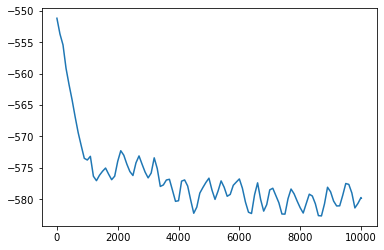

In [27]:
plt.plot(job.output.steps, job.output.energy_tot)

In [28]:
job.working_directory

'/home/jovyan/demo/lmp_large_hdf5/lmp_large'

In [29]:
!ls $job.working_directory

lmp_large.tar.bz2


In [30]:
job.decompress()

In [31]:
for l in job["log.lammps"]:
    if "Ave neighs/atom" in l:
        print(l)

Ave neighs/atom = 80.5312



# Master jobs 

In [32]:
structure = pr.create_ase_bulk("Al", cubic=True)

In [33]:
structure_strain = structure.copy()

In [34]:
strain = 0.9 

In [35]:
structure_strain.set_cell(structure.cell * strain, scale_atoms=True)

In [36]:
import numpy as np

In [37]:
strain_lst = np.linspace(0.9, 1.1, 11)

In [38]:
for strain in strain_lst: 
    structure_strain = structure.copy()
    structure_strain.set_cell(structure.cell * strain, scale_atoms=True)
    job = pr.create_job(job_type=pr.job_type.Lammps, job_name="s_" + str(strain).replace(".", "_"))
    job.structure = structure_strain
    job.potential = job.list_potentials()[0]
    job.run()

The job s_0_9 was saved and received the ID: 2
The job s_0_92 was saved and received the ID: 3
The job s_0_9400000000000001 was saved and received the ID: 4
The job s_0_9600000000000001 was saved and received the ID: 5
The job s_0_9800000000000001 was saved and received the ID: 6
The job s_1_0 was saved and received the ID: 7
The job s_1_02 was saved and received the ID: 8
The job s_1_04 was saved and received the ID: 9
The job s_1_06 was saved and received the ID: 10
The job s_1_08 was saved and received the ID: 11
The job s_1_1 was saved and received the ID: 12


In [39]:
volume_lst, energy_lst = [], [] 
for strain in strain_lst: 
    structure_strain = structure.copy()
    structure_strain.set_cell(structure.cell * strain, scale_atoms=True)
    job = pr.create_job(job_type=pr.job_type.Lammps, job_name="s_" + str(strain).replace(".", "_"))
    job.structure = structure_strain
    job.potential = job.list_potentials()[0]
    job.run()
    volume_lst.append(job.output.volume[-1])
    energy_lst.append(job.output.energy_tot[-1])

2020-08-07 16:10:56,705 - pyiron_log - WARNING - The job s_0_9 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-08-07 16:10:58,176 - pyiron_log - WARNING - The job s_0_92 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-08-07 16:10:59,604 - pyiron_log - WARNING - The job s_0_9400000000000001 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-08-07 16:11:01,001 - pyiron_log - WARNING - The job s_0_9600000000000001 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-08-07 16:11:02,504 - pyiron_log - WARNING - The job s_0_9800000000000001 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-08-07 16:11:03,908 - pyiron_log - WARNING - The job s_1_0 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-08-07 16:11:05,389 - pyiron_log - WARNING - The job s_1_02 is being loaded instead of runni

In [40]:
volume_lst, energy_lst = [], [] 
for strain in strain_lst: 
    # structure_strain = structure.copy()
    # structure_strain.set_cell(structure.cell * strain, scale_atoms=True)
    # job = pr.create_job(job_type=pr.job_type.Lammps, job_name="s_" + str(strain).replace(".", "_"))
    job = pr.inspect("s_" + str(strain).replace(".", "_"))
    # job.structure = structure_strain
    # job.potential = job.list_potentials()[0]
    # job.run()
    volume_lst.append(job["output/generic/volume"][-1])
    energy_lst.append(job["output/generic/energy_tot"][-1])

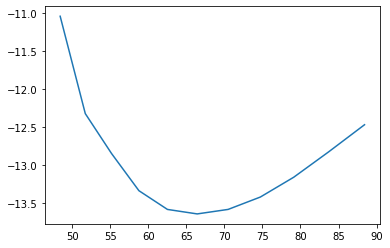

In [41]:
plt.plot(volume_lst, energy_lst)

In [42]:
job = pr.create_job(job_type=pr.job_type.Lammps, job_name="template")
job.structure = structure
job.potential = job.list_potentials()[0]

In [43]:
murn = job.create_job(pr.job_type.Murnaghan, "murn")

In [44]:
murn.input

,Parameter,Value,Comment
0,num_points,11,number of sample points
1,fit_type,polynomial,"['polynomial', 'birch', 'birchmurnaghan', 'murnaghan', 'pouriertarantola', 'vinet']"
2,fit_order,3,order of the fit polynom
3,vol_range,0.1,relative volume variation around volume defined by ref_ham


In [45]:
murn.run()

The job murn was saved and received the ID: 13
The job strain_0_9 was saved and received the ID: 14
The job strain_0_92 was saved and received the ID: 15
The job strain_0_94 was saved and received the ID: 16
The job strain_0_96 was saved and received the ID: 17
The job strain_0_98 was saved and received the ID: 18
The job strain_1_0 was saved and received the ID: 19
The job strain_1_02 was saved and received the ID: 20
The job strain_1_04 was saved and received the ID: 21
The job strain_1_06 was saved and received the ID: 22
The job strain_1_08 was saved and received the ID: 23
The job strain_1_1 was saved and received the ID: 24
job_id:  14 finished
job_id:  15 finished
job_id:  16 finished
job_id:  17 finished
job_id:  18 finished
job_id:  19 finished
job_id:  20 finished
job_id:  21 finished
job_id:  22 finished
job_id:  23 finished
job_id:  24 finished


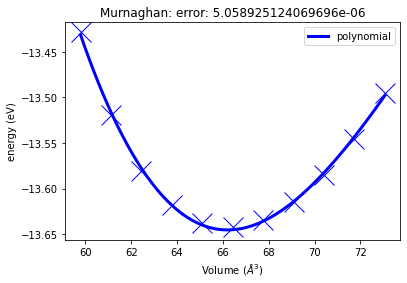

In [46]:
murn.plot()

# Skript Job

In [47]:
script = pr.create_job(pr.job_type.ScriptJob, "script")

In [48]:
script.script_path = "demo.ipynb"

In [49]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,Al192,lmp_large,/lmp_large,/home/jovyan/,demo/,2020-08-07 16:10:11.899242,2020-08-07 16:10:23.298220,11.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
1,2,finished,Al4,s_0_9,/s_0_9,/home/jovyan/,demo/,2020-08-07 16:10:32.002104,2020-08-07 16:10:32.701522,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
2,3,finished,Al4,s_0_92,/s_0_92,/home/jovyan/,demo/,2020-08-07 16:10:34.785569,2020-08-07 16:10:35.591671,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
3,4,finished,Al4,s_0_9400000000000001,/s_0_9400000000000001,/home/jovyan/,demo/,2020-08-07 16:10:37.290921,2020-08-07 16:10:37.901531,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
4,5,finished,Al4,s_0_9600000000000001,/s_0_9600000000000001,/home/jovyan/,demo/,2020-08-07 16:10:39.600201,2020-08-07 16:10:40.190459,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
5,6,finished,Al4,s_0_9800000000000001,/s_0_9800000000000001,/home/jovyan/,demo/,2020-08-07 16:10:41.781126,2020-08-07 16:10:42.306616,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
6,7,finished,Al4,s_1_0,/s_1_0,/home/jovyan/,demo/,2020-08-07 16:10:43.813299,2020-08-07 16:10:44.499203,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
7,8,finished,Al4,s_1_02,/s_1_02,/home/jovyan/,demo/,2020-08-07 16:10:45.905039,2020-08-07 16:10:46.687578,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
8,9,finished,Al4,s_1_04,/s_1_04,/home/jovyan/,demo/,2020-08-07 16:10:48.105760,2020-08-07 16:10:48.774412,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
9,10,finished,Al4,s_1_06,/s_1_06,/home/jovyan/,demo/,2020-08-07 16:10:50.286128,2020-08-07 16:10:50.792143,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN


# pyiron table

In [50]:
table = pr.create_table()

In [51]:
def myfilter(job): 
    return "strain" in job.job_name

In [52]:
table.filter_function = myfilter

In [53]:
table.add.get_volume

True

In [54]:
table.add.get_energy_tot

True

In [55]:
def len_job_name(job):
    return len(job.job_name)

In [56]:
table.add["len"] = len_job_name

In [57]:
table.run()

100%|██████████| 11/11 [00:00<00:00, 104.40it/s]

The job table was saved and received the ID: 25



2020-08-07 16:11:46,615 - pyiron_log - WARNING - The job table is being loaded instead of running. To re-run use the argument 'run_again=True'


In [58]:
df = table.get_dataframe()
df 

,job_id,energy_tot,volume,len
0,14,-13.428526,59.787112,10
1,15,-13.519023,61.115715,11
2,16,-13.580416,62.444317,11
3,17,-13.618512,63.772920,11
4,18,-13.638014,65.101522,11
5,19,-13.642432,66.430125,10
6,20,-13.634209,67.758727,11
7,21,-13.614879,69.087330,11
8,22,-13.585168,70.415932,11
9,23,-13.545276,71.744535,11


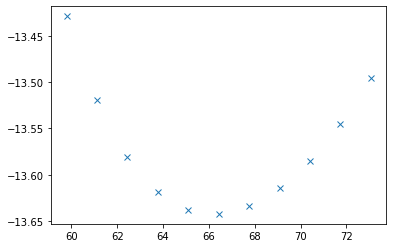

In [59]:
plt.plot(df.volume, df.energy_tot, "x")

# Performance of interactive jobs 

In [60]:
job = pr.create_job(job_type=pr.job_type.Lammps, job_name="template")
job.structure = structure
job.potential = job.list_potentials()[0]
job.server.run_mode.interactive = True
murn = job.create_job(pr.job_type.Murnaghan, "murn2")
murn.run()

The job murn2 was saved and received the ID: 26
The job murn2_template was saved and received the ID: 27


In [61]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,Al192,lmp_large,/lmp_large,/home/jovyan/,demo/,2020-08-07 16:10:11.899242,2020-08-07 16:10:23.298220,11.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
1,2,finished,Al4,s_0_9,/s_0_9,/home/jovyan/,demo/,2020-08-07 16:10:32.002104,2020-08-07 16:10:32.701522,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
2,3,finished,Al4,s_0_92,/s_0_92,/home/jovyan/,demo/,2020-08-07 16:10:34.785569,2020-08-07 16:10:35.591671,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
3,4,finished,Al4,s_0_9400000000000001,/s_0_9400000000000001,/home/jovyan/,demo/,2020-08-07 16:10:37.290921,2020-08-07 16:10:37.901531,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
4,5,finished,Al4,s_0_9600000000000001,/s_0_9600000000000001,/home/jovyan/,demo/,2020-08-07 16:10:39.600201,2020-08-07 16:10:40.190459,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
5,6,finished,Al4,s_0_9800000000000001,/s_0_9800000000000001,/home/jovyan/,demo/,2020-08-07 16:10:41.781126,2020-08-07 16:10:42.306616,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
6,7,finished,Al4,s_1_0,/s_1_0,/home/jovyan/,demo/,2020-08-07 16:10:43.813299,2020-08-07 16:10:44.499203,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
7,8,finished,Al4,s_1_02,/s_1_02,/home/jovyan/,demo/,2020-08-07 16:10:45.905039,2020-08-07 16:10:46.687578,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
8,9,finished,Al4,s_1_04,/s_1_04,/home/jovyan/,demo/,2020-08-07 16:10:48.105760,2020-08-07 16:10:48.774412,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
9,10,finished,Al4,s_1_06,/s_1_06,/home/jovyan/,demo/,2020-08-07 16:10:50.286128,2020-08-07 16:10:50.792143,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dnist-2dworkshop-2dfpacxvuk#1,Lammps,0.1,None,NaN
